In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.div import UnaryDiv
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

--- 0.6460006237030029 seconds ---
dividend error:  tensor(-0.0058, device='cuda:0') tensor(0.0020, device='cuda:0')
divisor  error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
quotient error:  tensor(-0.4922, device='cuda:0') tensor(0.4961, device='cuda:0')
dividend: tensor([[0.6485, 0.3349, 0.3395,  ..., 0.5453, 0.4355, 0.0305]],
       device='cuda:0')
divisor: tensor([[0.9766, 0.5195, 0.4219,  ..., 0.6680, 0.7852, 0.3555]],
       device='cuda:0')
quotient: tensor([[0.6641, 0.6445, 0.8047,  ..., 0.8164, 0.5547, 0.0859]],
       device='cuda:0')
RMSE 0.04688419506168397
MAE 0.022623828
bias 0.00092226564


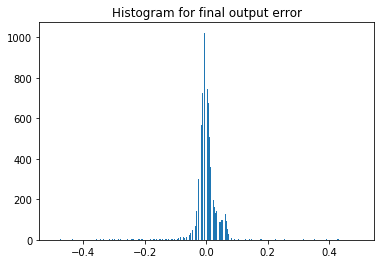

[ 0.0078125  -0.0078125   0.01171875 ... -0.00390625  0.0625
 -0.0078125 ]
7372 6072
-0.4921875 0.49609375
tensor(0.0078, device='cuda:0') tensor(1.5259e-05, device='cuda:0')
tensor(0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
--- 1.2740013599395752 seconds ---
dividend error:  tensor(-0.0117, device='cuda:0') tensor(0.0039, device='cuda:0')
divisor  error:  tensor(-0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
quotient error:  tensor(-1.2227, device='cuda:0') tensor(1.9688, device='cuda:0')
dividend: tensor([[-0.3475, -0.7257,  0.0741,  ..., -0.1950, -0.2000, -0.4139]],
       device='cuda:0')
divisor: tensor([[ 0.4062,  0.8008,  0.0898,  ..., -0.3008, -0.4062, -0.6836]],
       device='cuda:0')
quotient: tensor([[-0.8555, -0.9062,  0.8242,  ...,  0.6484,  0.4922,  0.6055]],
       device='cuda:0')
RMSE 0.18349399301119207
MAE 0.09418711
bias 0.051845703


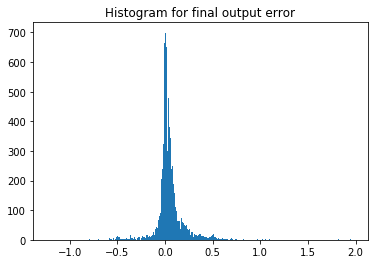

[ 0.05859375  0.0625     -0.04296875 ...  0.09375     0.078125
  0.07421875]
4459 6093
-1.2226562 1.96875
tensor(0.0038, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0078, device='cuda:0') tensor(-0., device='cuda:0')


In [4]:
col = 10000
modes = ["unipolar", "bipolar"]
static = True
depth_abs=4
depth_kernel=4
depth_sync=2
shiftreg=False
mode="bipolar"
rng="Sobol"
rng_dim=4
bstype=torch.float
buftype=torch.float
bitwidth = 8
bstype = torch.float
randtype = torch.float

for mode in modes:
    if mode is "unipolar":
        quotient = torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        divisor = torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    elif mode is "bipolar":
        quotient = torch.rand(1, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        divisor = torch.rand(1, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_div = UnaryDiv(depth_abs=depth_abs, 
                       depth_kernel=depth_kernel, 
                       depth_sync=depth_sync, 
                       shiftreg=shiftreg, 
                       mode=mode, 
                       rng=rng, 
                       rng_dim=rng_dim, 
                       bstype=bstype, 
                       buftype=buftype).to(device)

    dividend = torch.mul(quotient, divisor).to(device)

    quotientPE = ProgressiveError(quotient, mode=mode).to(device)

    dividendPE = ProgressiveError(dividend, mode=mode).to(device)
    dividendSRC = SourceGen(dividend, bitwidth, mode=mode, randtype=randtype)().to(device)
    dividendRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    dividendBS = BSGen(dividendSRC, dividendRNG, bstype).to(device)
    
    divisorPE  = ProgressiveError(divisor,  mode=mode).to(device)
    divisorSRC = SourceGen(divisor, bitwidth, mode=mode, randtype=randtype)().to(device)
    divisorRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    divisorBS = BSGen(divisorSRC, divisorRNG, bstype).to(device)

    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            dividend_bs = dividendBS(torch.tensor([i]))
            dividendPE.Monitor(dividend_bs)

            divisor_bs = divisorBS(torch.tensor([i]))
            divisorPE.Monitor(divisor_bs)
            
            quotient_bs = dut_div(dividend_bs, divisor_bs)   
            quotientPE.Monitor(quotient_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("dividend error: ", torch.min(dividendPE()[1]), torch.max(dividendPE()[1]))
        print("divisor  error: ", torch.min(divisorPE()[1]), torch.max(divisorPE()[1]))
        
        print("quotient error: ", torch.min(quotientPE()[1]), torch.max(quotientPE()[1]))
        
        print("dividend:", dividend)
        print("divisor:", divisor)
        print("quotient:", quotient)
        
        result_pe = quotientPE()[1].view(-1).cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("MAE", np.mean(np.abs(result_pe)))
        print("bias", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()
        print(result_pe)
        print(result_pe.argmin(), result_pe.argmax())
        print(result_pe[result_pe.argmin()], result_pe[result_pe.argmax()])
        print(dividend[0, result_pe.argmin()], dividend[0, result_pe.argmax()])
        print(divisor[0, result_pe.argmin()], divisor[0, result_pe.argmax()])